In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode labels
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
latent_dim = 2  # 2D latent space for visualization

# Inputs
image_input = layers.Input(shape=(28, 28, 1))
label_input = layers.Input(shape=(num_classes,))

# Flatten image and repeat label to match spatial size
x = layers.Flatten()(image_input)
x = layers.Concatenate()([x, label_input])  # Combine image + label
x = layers.Dense(256, activation="relu")(x)

# Latent variables
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = models.Model([image_input, label_input], [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 794)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    203,520 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 204,548 (799.02 KB)

 Trainable params: 204,548 (799.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
latent_input = layers.Input(shape=(latent_dim,))
label_input_dec = layers.Input(shape=(num_classes,))

x = layers.Concatenate()([latent_input, label_input_dec])
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
output = layers.Reshape((28, 28, 1))(x)

decoder = models.Model([latent_input, label_input_dec], output, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │      3,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 784)       │    201,488 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 204,816 (800.06 KB)

 Trainable params: 204,816 (800.06 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        (x, y) = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x, y])
            reconstruction = self.decoder([z, y])
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}


In [9]:
# Define CVAE with a robust train_step
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        # Handle the case where data comes as a single-element tuple
        if isinstance(data, tuple) and len(data) == 1:
            data = data[0]
        x, y = data  # unpack images and labels

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x, y])
            reconstruction = self.decoder([z, y])
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

# Instantiate and train CVAE
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam())
cvae.fit(x=(x_train, y_train), epochs=30, batch_size=128)


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - kl_loss: 7.7765 - loss: 187.7946 - reconstruction_loss: 180.0181
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - kl_loss: 4.1066 - loss: 148.1602 - reconstruction_loss: 144.0536
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - kl_loss: 4.2360 - loss: 142.5917 - reconstruction_loss: 138.3557
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - kl_loss: 4.2707 - loss: 140.1364 - reconstruction_loss: 135.8657
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - kl_loss: 4.2890 - loss: 138.5746 - reconstruction_loss: 134.2855
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 4.3165 - loss: 137.4247 - reconstruction_loss: 133.1082
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 4.3481 - loss: 136.5692 - reconstruction_loss: 132.2211
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - kl_loss: 4.3719 - loss: 135.8250 - reconstruction_loss: 131.4531
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


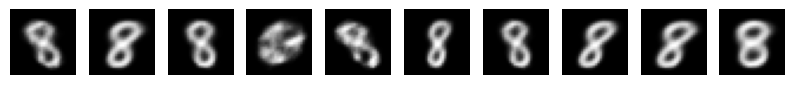

In [25]:
import matplotlib.pyplot as plt

def generate_digit(cvae, digit, latent_dim=2, n=10):
    label = np.zeros((1, 10))
    label[0, digit] = 1.0

    # Sample random latent vectors
    z_samples = np.random.normal(size=(n, latent_dim))

    plt.figure(figsize=(n, 1))
    for i, z_sample in enumerate(z_samples):
        x_decoded = cvae.decoder.predict([z_sample.reshape(1, -1), label])
        digit_img = x_decoded[0].reshape(28, 28)
        plt.subplot(1, n, i + 1)
        plt.imshow(digit_img, cmap="gray")
        plt.axis("off")
    plt.show()

# Example: generate handwritten 7s
generate_digit(cvae, digit=8)


In [23]:
encoder.save("cvae_encoder.h5")
decoder.save("cvae_decoder.h5")
